In [ ]:
#############################################
##########5[1]###############################
#############################################

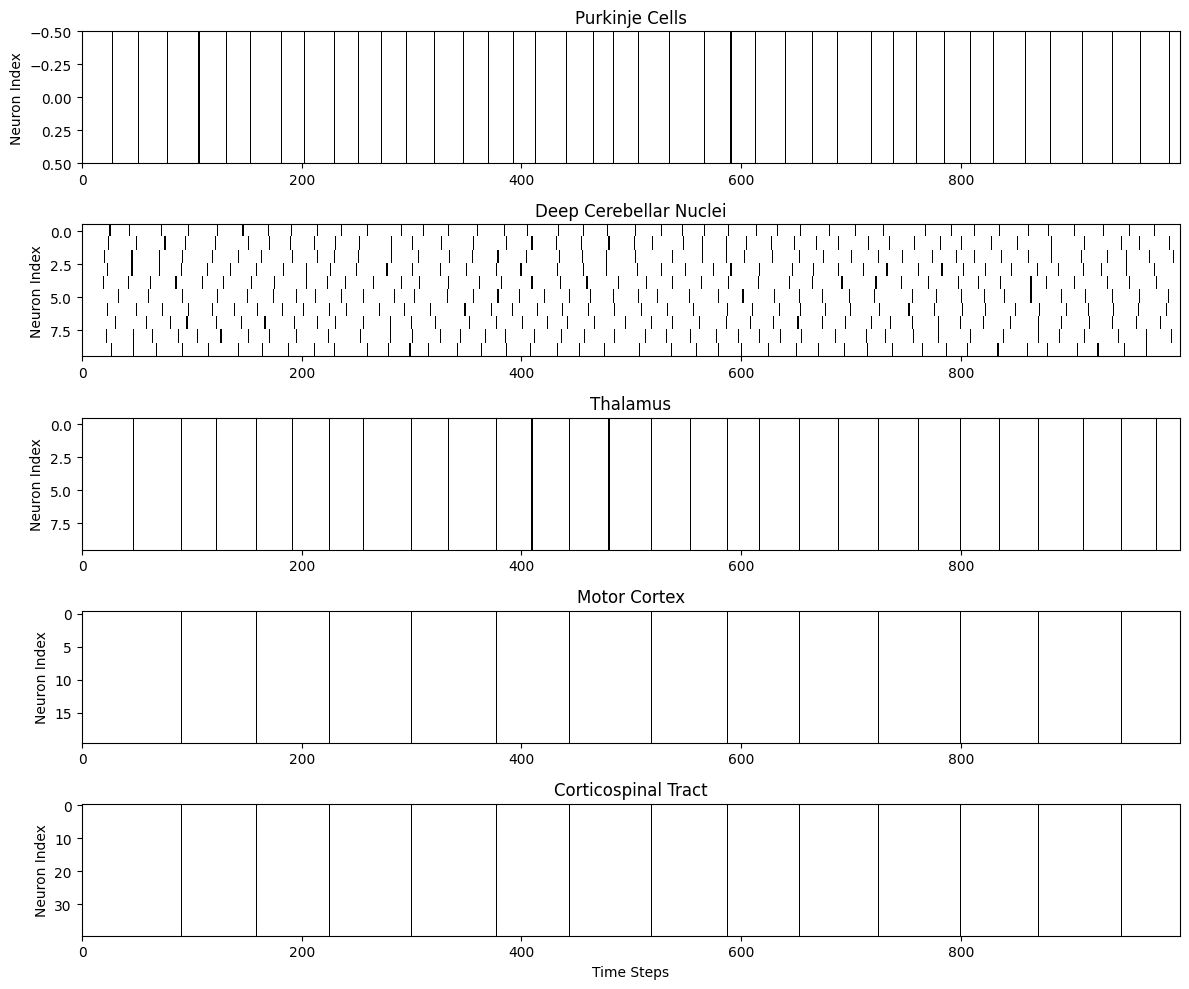

Purkinje Cells -> Spikes: 40, Rate: 0.40 Hz, Bursts: 40
Deep Cerebellar Nuclei -> Spikes: 420, Rate: 0.42 Hz, Bursts: 420
Thalamus -> Spikes: 270, Rate: 0.27 Hz, Bursts: 270
Motor Cortex -> Spikes: 260, Rate: 0.13 Hz, Bursts: 260
Corticospinal Tract -> Spikes: 520, Rate: 0.13 Hz, Bursts: 520


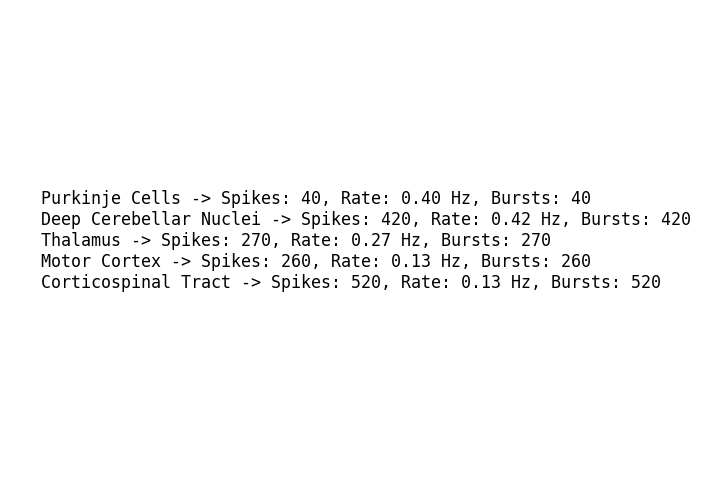

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import csv  # Added for CSV handling

# ========================
# Neuron Model (LIF)
# ========================
def lif_neuron(mem_prev, input_current, dt, tau_mem, threshold, reset_potential):
    new_mem = mem_prev + dt/tau_mem * (-mem_prev + input_current)
    spike = (new_mem >= threshold).astype(float)
    new_mem = np.where(spike, reset_potential, new_mem)
    return new_mem, spike

# ========================
# STDP Plasticity
# ========================
class STDP:
    def __init__(self, pre_dim, post_dim, tau_plus=20.0, tau_minus=20.0,
                 a_plus=0.1, a_minus=0.1):
        self.tau_plus = tau_plus
        self.tau_minus = tau_minus
        self.a_plus = a_plus
        self.a_minus = a_minus
        self.tr_pre = np.zeros(pre_dim)
        self.tr_post = np.zeros(post_dim)

    def update(self, pre_spike, post_spike, dt):
        self.tr_pre = self.tr_pre * (1 - dt/self.tau_plus) + pre_spike
        self.tr_post = self.tr_post * (1 - dt/self.tau_minus) + post_spike
        delta_w = (self.a_plus * np.outer(post_spike, self.tr_pre) -
                   self.a_minus * np.outer(self.tr_post, pre_spike))
        return delta_w

# ========================
# Simulation Core
# ========================
def simulate_model():
    # ... [keep identical simulation code from original] ...
    time_steps = 1000
    dt = 0.1  # time step (in seconds)
    
    # Double the cell numbers compared to the original:
    num_purkinje    = 10  # (was 10)
    num_dcn         = 10   # (was 5)
    num_thalamus    = 10   # (was 5)
    num_motor       = 20   # (was 10)
    num_corticospinal = 40  # (was 20)

    # Neuron parameters
    tau_mem = 7.0
    threshold = 1.0
    reset_potential = 0.0

    # Initialize STDP for the Purkinje -> DCN projection.
    stdp = STDP(pre_dim=num_purkinje, post_dim=num_dcn)

    # Generate random input currents for climbing and mossy fibers.
    climbing_fiber = 7.0 * np.random.rand(num_purkinje, time_steps)
    mossy_fiber    = 7.0 * np.random.rand(num_dcn, time_steps)

    # Allocate arrays for membrane potentials and spikes.
    purk_mem   = np.zeros((num_purkinje, time_steps))
    dcn_mem    = np.zeros((num_dcn, time_steps))
    thal_mem   = np.zeros((num_thalamus, time_steps))
    motor_mem  = np.zeros((num_motor, time_steps))
    cortico_mem = np.zeros((num_corticospinal, time_steps))

    purk_spk   = np.zeros((num_purkinje, time_steps))
    dcn_spk    = np.zeros((num_dcn, time_steps))
    thal_spk   = np.zeros((num_thalamus, time_steps))
    motor_spk  = np.zeros((num_motor, time_steps))
    cortico_spk = np.zeros((num_corticospinal, time_steps))

    # Synaptic weights (note that the dimensions now match the doubled cell numbers)
    w_purkinje_dcn  = -1.2 * np.ones((num_dcn, num_purkinje))
    w_dcn_thalamus  = 6.0  * np.ones((num_thalamus, num_dcn))
    w_thalamus_motor = 6.0 * np.ones((num_motor, num_thalamus))
    w_motor_cortico = 6.0 * np.ones((num_corticospinal, num_motor))
    w_motor_dcn     = 0.5 * np.ones((num_dcn, num_motor))

    # This is used to provide feedback to the DCN
    motor_spk_prev = np.zeros(num_motor)

    # Main simulation loop
    for t in range(1, time_steps):
        # Purkinje cells
        purk_mem[:, t], purk_spk[:, t] = lif_neuron(
            purk_mem[:, t-1],
            climbing_fiber[:, t],
            dt, tau_mem, threshold, reset_potential
        )

        # DCN: combine mossy fiber input, inhibitory input from Purkinje, and feedback from Motor
        feedback = np.dot(w_motor_dcn, motor_spk_prev)
        dcn_input = mossy_fiber[:, t] + np.dot(w_purkinje_dcn, purk_spk[:, t]) + feedback
        dcn_mem[:, t], dcn_spk[:, t] = lif_neuron(
            dcn_mem[:, t-1],
            dcn_input,
            dt, tau_mem, threshold, reset_potential
        )
        # Update the Purkinje->DCN synaptic weights via STDP
        delta_w = stdp.update(purk_spk[:, t], dcn_spk[:, t], dt)
        w_purkinje_dcn += delta_w

        # Thalamus
        thal_input = np.dot(w_dcn_thalamus, dcn_spk[:, t])
        thal_mem[:, t], thal_spk[:, t] = lif_neuron(
            thal_mem[:, t-1],
            thal_input,
            dt, tau_mem, threshold, reset_potential
        )

        # Motor cortex
        motor_input = np.dot(w_thalamus_motor, thal_spk[:, t])
        motor_mem[:, t], motor_spk[:, t] = lif_neuron(
            motor_mem[:, t-1],
            motor_input,
            dt, tau_mem, threshold, reset_potential
        )
        motor_spk_prev = motor_spk[:, t].copy()

        # Corticospinal tract
        cortico_input = np.dot(w_motor_cortico, motor_spk[:, t])
        cortico_mem[:, t], cortico_spk[:, t] = lif_neuron(
            cortico_mem[:, t-1],
            cortico_input,
            dt, tau_mem, threshold, reset_potential
        )

    return purk_spk, dcn_spk, thal_spk, motor_spk, cortico_spk, dt

# ========================
# Quantification Functions
# ========================
def quantify_spikes_per_neuron(spike_data, dt):
    num_neurons = spike_data.shape[0]
    sim_time = dt * spike_data.shape[1]
    
    results = []
    for idx in range(num_neurons):
        neuron_spikes = spike_data[idx, :]
        total = np.sum(neuron_spikes)
        rate = total / sim_time
        bursts = np.sum(np.diff(np.insert(neuron_spikes, 0, 0)) == 1)
        
        results.append({
            "Neuron": idx+1,
            "Spikes": total,
            "Rate": rate,
            "Bursts": bursts
        })
    return results

# ========================
# CSV Export Function
# ========================
def export_neuron_stats(all_data):
    with open('5[1].csv', 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=[
            'Neuron Group', 'Neuron ID', 'Spike Count', 
            'Firing Rate (Hz)', 'Burst Count'
        ])
        writer.writeheader()
        
        for group_data in all_data:
            group_name = group_data['group']
            for neuron in group_data['neurons']:
                writer.writerow({
                    'Neuron Group': group_name,
                    'Neuron ID': f"{group_name} {neuron['Neuron']}",
                    'Spike Count': int(neuron['Spikes']),
                    'Firing Rate (Hz)': round(neuron['Rate'], 4),
                    'Burst Count': int(neuron['Bursts'])
                })

# ========================
# Main Execution
# ========================
if __name__ == "__main__":
    # Run simulation
    p_spk, d_spk, th_spk, m_spk, c_spk, dt = simulate_model()

    # Collect data from all groups
    all_groups = [
        {'group': 'Purkinje', 'data': p_spk},
        {'group': 'DCN', 'data': d_spk},
        {'group': 'Thalamus', 'data': th_spk},
        {'group': 'MotorCortex', 'data': m_spk},
        {'group': 'Corticospinal', 'data': c_spk}
    ]

    # Process all groups
    analysis_data = []
    for group in all_groups:
        stats = quantify_spikes_per_neuron(group['data'], dt)
        analysis_data.append({
            'group': group['group'],
            'neurons': stats
        })

    # Export to CSV
    export_neuron_stats(analysis_data)

    # Generate plots (original plotting code)
        # Plot the spike raster for each layer
    plt.figure(figsize=(12, 10))
    layers = [
        ("Purkinje Cells", p_spk),
        ("Deep Cerebellar Nuclei", d_spk),
        ("Thalamus", th_spk),
        ("Motor Cortex", m_spk),
        ("Corticospinal Tract", c_spk)
    ]
    for idx, (name, spk_data) in enumerate(layers):
        plt.subplot(5, 1, idx+1)
        plt.title(name)
        plt.imshow(spk_data, aspect='auto', cmap='binary', interpolation='none')
        plt.ylabel("Neuron Index")
        if idx == 4:
            plt.xlabel("Time Steps")
    plt.tight_layout()
    plt.savefig("5[1].svg", format="svg")
    plt.show()

    # Compute and print the quantification results for each layer.
    summary_lines = []
    for name, spk_data in layers:
        total_spikes, avg_rate, bursts = quantify_spikes(spk_data, dt)
        line = f"{name} -> Spikes: {int(total_spikes)}, Rate: {avg_rate:.2f} Hz, Bursts: {int(bursts)}"
        summary_lines.append(line)
        print(line)
    
    summary_text = "\n".join(summary_lines)

    # Create a figure to display the summary text and save it as an SVG.
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')
    ax.text(0.05, 0.5, summary_text, fontsize=12, fontfamily='monospace', va='center')
    plt.show()

In [2]:
#############################################
##########5[2]###############################
#############################################

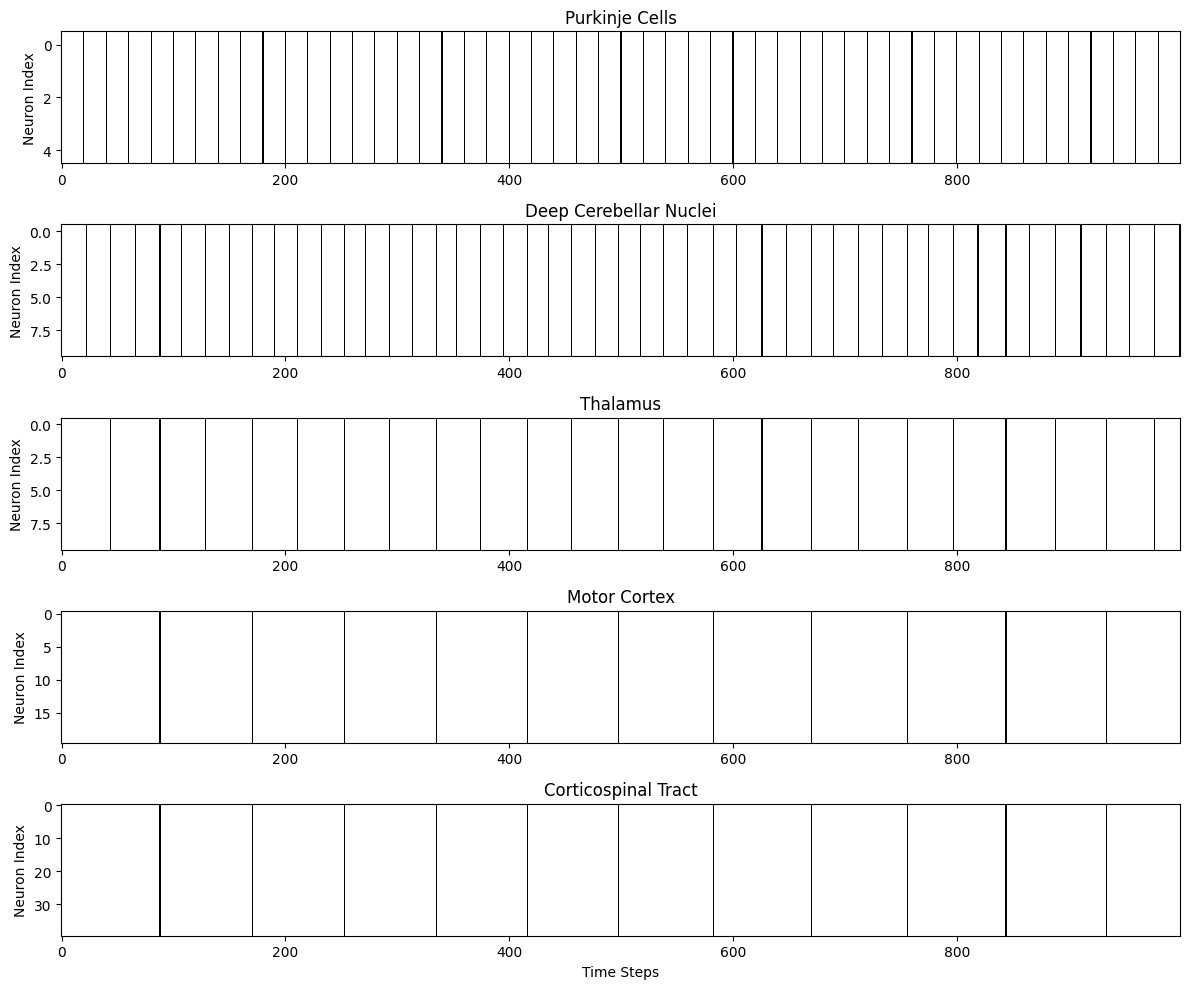

Purkinje Cells -> Spikes: 245, Rate: 0.49 Hz, Bursts: 245
Deep Cerebellar Nuclei -> Spikes: 470, Rate: 0.47 Hz, Bursts: 470
Thalamus -> Spikes: 230, Rate: 0.23 Hz, Bursts: 230
Motor Cortex -> Spikes: 220, Rate: 0.11 Hz, Bursts: 220
Corticospinal Tract -> Spikes: 440, Rate: 0.11 Hz, Bursts: 440


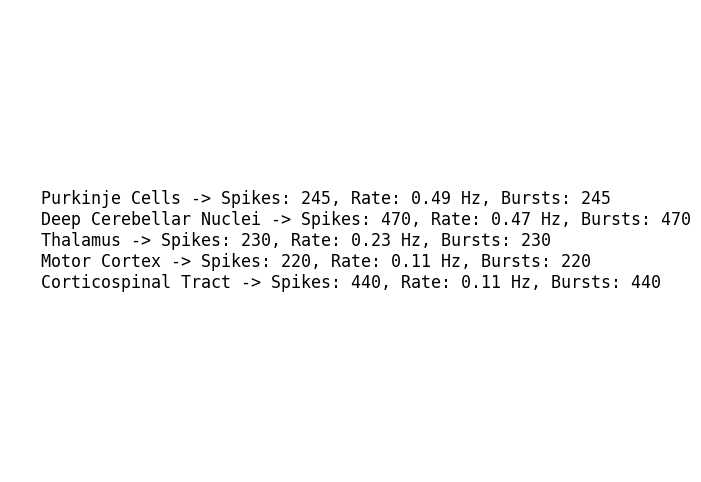

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# ========================
# Neuron Model (LIF)
# ========================
def lif_neuron(mem_prev, input_current, dt, tau_mem, threshold, reset_potential):
    """
    Leaky Integrate-and-Fire neuron model.
    
    (This basic model does not include a detailed refractory period or complex bursting dynamics.
    For biological realism, you might add such mechanisms.)
    """
    # Euler integration of the membrane potential
    new_mem = mem_prev + dt/tau_mem * (-mem_prev + input_current)
    # A spike is generated when the membrane potential exceeds the threshold.
    spike = (new_mem >= threshold).astype(float)
    # Reset membrane potential immediately upon spiking
    new_mem = np.where(spike, reset_potential, new_mem)
    return new_mem, spike

# ========================
# STDP Plasticity
# ========================
class STDP:
    def __init__(self, pre_dim, post_dim, tau_plus=20.0, tau_minus=20.0,
                 a_plus=0.1, a_minus=0.1):
        self.tau_plus = tau_plus
        self.tau_minus = tau_minus
        self.a_plus = a_plus
        self.a_minus = a_minus
        self.tr_pre = np.zeros(pre_dim)   # Trace for presynaptic neurons
        self.tr_post = np.zeros(post_dim)   # Trace for postsynaptic neurons

    def update(self, pre_spike, post_spike, dt):
        # Update traces (exponential decay + spike contribution)
        self.tr_pre = self.tr_pre * (1 - dt/self.tau_plus) + pre_spike
        self.tr_post = self.tr_post * (1 - dt/self.tau_minus) + post_spike
        # Compute weight change based on the spike traces
        delta_w = (self.a_plus * np.outer(post_spike, self.tr_pre) -
                   self.a_minus * np.outer(self.tr_post, pre_spike))
        return delta_w

# ========================
# Simulation Core (with doubled cell numbers and constant inputs)
# ========================
def simulate_model():
    time_steps = 1000
    dt = 0.1  # time step (in seconds)
    
    # Double the cell numbers compared to the original:
    num_purkinje     = 5   # (was 10)
    num_dcn          = 10   # (was 5)
    num_thalamus     = 10   # (was 5)
    num_motor        = 20   # (was 10)
    num_corticospinal = 40  # (was 20)

    # Neuron parameters
    tau_mem = 7.0
    threshold = 1.0
    reset_potential = 0.0

    # Initialize STDP for the Purkinje -> DCN projection.
    stdp = STDP(pre_dim=num_purkinje, post_dim=num_dcn)

    # Instead of random noise, use constant input currents for climbing and mossy fibers.
    # For example, set all values to a constant level.
    constant_climbing_current = 4.0  # you may adjust this constant as needed
    constant_mossy_current    = 4.0  # you may adjust this constant as needed
    climbing_fiber = constant_climbing_current * np.ones((num_purkinje, time_steps))
    mossy_fiber    = constant_mossy_current    * np.ones((num_dcn, time_steps))

    # Allocate arrays for membrane potentials and spikes.
    purk_mem    = np.zeros((num_purkinje, time_steps))
    dcn_mem     = np.zeros((num_dcn, time_steps))
    thal_mem    = np.zeros((num_thalamus, time_steps))
    motor_mem   = np.zeros((num_motor, time_steps))
    cortico_mem = np.zeros((num_corticospinal, time_steps))

    purk_spk    = np.zeros((num_purkinje, time_steps))
    dcn_spk     = np.zeros((num_dcn, time_steps))
    thal_spk    = np.zeros((num_thalamus, time_steps))
    motor_spk   = np.zeros((num_motor, time_steps))
    cortico_spk = np.zeros((num_corticospinal, time_steps))

    # Synaptic weights (note that the dimensions now match the doubled cell numbers)
    w_purkinje_dcn   = -1.2 * np.ones((num_dcn, num_purkinje))
    w_dcn_thalamus   = 6.0  * np.ones((num_thalamus, num_dcn))
    w_thalamus_motor = 6.0  * np.ones((num_motor, num_thalamus))
    w_motor_cortico  = 6.0  * np.ones((num_corticospinal, num_motor))
    w_motor_dcn      = 0.5  * np.ones((num_dcn, num_motor))

    # This is used to provide feedback to the DCN
    motor_spk_prev = np.zeros(num_motor)

    # Main simulation loop
    for t in range(1, time_steps):
        # Purkinje cells
        purk_mem[:, t], purk_spk[:, t] = lif_neuron(
            purk_mem[:, t-1],
            climbing_fiber[:, t],
            dt, tau_mem, threshold, reset_potential
        )

        # DCN: combine mossy fiber input, inhibitory input from Purkinje, and feedback from Motor
        feedback = np.dot(w_motor_dcn, motor_spk_prev)
        dcn_input = mossy_fiber[:, t] + np.dot(w_purkinje_dcn, purk_spk[:, t]) + feedback
        dcn_mem[:, t], dcn_spk[:, t] = lif_neuron(
            dcn_mem[:, t-1],
            dcn_input,
            dt, tau_mem, threshold, reset_potential
        )
        # Update the Purkinje->DCN synaptic weights via STDP
        delta_w = stdp.update(purk_spk[:, t], dcn_spk[:, t], dt)
        w_purkinje_dcn += delta_w

        # Thalamus
        thal_input = np.dot(w_dcn_thalamus, dcn_spk[:, t])
        thal_mem[:, t], thal_spk[:, t] = lif_neuron(
            thal_mem[:, t-1],
            thal_input,
            dt, tau_mem, threshold, reset_potential
        )

        # Motor cortex
        motor_input = np.dot(w_thalamus_motor, thal_spk[:, t])
        motor_mem[:, t], motor_spk[:, t] = lif_neuron(
            motor_mem[:, t-1],
            motor_input,
            dt, tau_mem, threshold, reset_potential
        )
        motor_spk_prev = motor_spk[:, t].copy()

        # Corticospinal tract
        cortico_input = np.dot(w_motor_cortico, motor_spk[:, t])
        cortico_mem[:, t], cortico_spk[:, t] = lif_neuron(
            cortico_mem[:, t-1],
            cortico_input,
            dt, tau_mem, threshold, reset_potential
        )

    return purk_spk, dcn_spk, thal_spk, motor_spk, cortico_spk, dt

# ========================
# Quantification Functions
# ========================
def quantify_spikes_per_neuron(spike_data, dt):
    num_neurons = spike_data.shape[0]
    sim_time = dt * spike_data.shape[1]
    
    results = []
    for idx in range(num_neurons):
        neuron_spikes = spike_data[idx, :]
        total = np.sum(neuron_spikes)
        rate = total / sim_time
        bursts = np.sum(np.diff(np.insert(neuron_spikes, 0, 0)) == 1)
        
        results.append({
            "Neuron": idx+1,
            "Spikes": total,
            "Rate": rate,
            "Bursts": bursts
        })
    return results

# ========================
# CSV Export Function
# ========================
def export_neuron_stats(all_data):
    with open('5[2].csv', 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=[
            'Neuron Group', 'Neuron ID', 'Spike Count', 
            'Firing Rate (Hz)', 'Burst Count'
        ])
        writer.writeheader()
        
        for group_data in all_data:
            group_name = group_data['group']
            for neuron in group_data['neurons']:
                writer.writerow({
                    'Neuron Group': group_name,
                    'Neuron ID': f"{group_name} {neuron['Neuron']}",
                    'Spike Count': int(neuron['Spikes']),
                    'Firing Rate (Hz)': round(neuron['Rate'], 4),
                    'Burst Count': int(neuron['Bursts'])
                })

# ========================
# Main Execution and Plotting
# ========================
if __name__ == "__main__":
    # Run the simulation
    p_spk, d_spk, th_spk, m_spk, c_spk, dt = simulate_model()

        # Collect data from all groups
    all_groups = [
        {'group': 'Purkinje', 'data': p_spk},
        {'group': 'DCN', 'data': d_spk},
        {'group': 'Thalamus', 'data': th_spk},
        {'group': 'MotorCortex', 'data': m_spk},
        {'group': 'Corticospinal', 'data': c_spk}
    ]

    # Process all groups
    analysis_data = []
    for group in all_groups:
        stats = quantify_spikes_per_neuron(group['data'], dt)
        analysis_data.append({
            'group': group['group'],
            'neurons': stats
        })

    # Export to CSV
    export_neuron_stats(analysis_data)

    # Plot the spike raster for each layer
    plt.figure(figsize=(12, 10))
    layers = [
        ("Purkinje Cells", p_spk),
        ("Deep Cerebellar Nuclei", d_spk),
        ("Thalamus", th_spk),
        ("Motor Cortex", m_spk),
        ("Corticospinal Tract", c_spk)
    ]
    for idx, (name, spk_data) in enumerate(layers):
        plt.subplot(5, 1, idx+1)
        plt.title(name)
        plt.imshow(spk_data, aspect='auto', cmap='binary', interpolation='none')
        plt.ylabel("Neuron Index")
        if idx == 4:
            plt.xlabel("Time Steps")
    plt.tight_layout()
    plt.savefig("5[2].svg", format="svg")
    plt.show()

    # Compute and print the quantification results for each layer.
    summary_lines = []
    for name, spk_data in layers:
        total_spikes, avg_rate, bursts = quantify_spikes(spk_data, dt)
        line = f"{name} -> Spikes: {int(total_spikes)}, Rate: {avg_rate:.2f} Hz, Bursts: {int(bursts)}"
        summary_lines.append(line)
        print(line)
    
    summary_text = "\n".join(summary_lines)

    # Create a figure to display the summary text and save it as an SVG.
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')
    ax.text(0.05, 0.5, summary_text, fontsize=12, fontfamily='monospace', va='center')
    plt.show()


In [ ]:
#############################################
##########5[3]###############################
#############################################

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import csv

# ========================
# Enhanced Neuron Model (LIF with refractory period and adaptation)
# ========================
def lif_neuron(mem_prev, input_current, dt, params):
    """Leaky Integrate-and-Fire with refractory period, adaptation and noise"""
    if hasattr(params, 'ref_count'):
        if params.ref_count > 0:
            params.ref_count -= 1
            return mem_prev, 0, params.adapt_current
    
    noise = params.noise_scale * np.random.randn(*mem_prev.shape)
    new_mem = mem_prev + dt/params.tau_mem * (-mem_prev + input_current - params.adapt_current) + noise
    spike = (new_mem >= params.threshold).astype(float)
    
    if spike:
        new_mem = params.reset_potential
        params.ref_count = int(params.ref_period/dt)
        params.adapt_current = params.adapt_current + params.adapt_increment
    else:
        params.adapt_current *= params.adapt_decay
        
    return new_mem, spike, params.adapt_current

class NeuronParams:
    def __init__(self, population):
        self.population = population
        params = {
            'Purkinje': {'tau_mem': 10.0, 'threshold': -55.0, 'reset': -70.0, 'noise': 0.3},
            'DCN': {'tau_mem': 20.0, 'threshold': -50.0, 'reset': -65.0, 'noise': 0.2},
            'Thalamus': {'tau_mem': 25.0, 'threshold': -54.0, 'reset': -65.0, 'noise': 0.2},
            'Motor': {'tau_mem': 20.0, 'threshold': -52.0, 'reset': -65.0, 'noise': 0.25},
            'Corticospinal': {'tau_mem': 30.0, 'threshold': -53.0, 'reset': -65.0, 'noise': 0.2}
        }
        p = params[population]
        
        self.tau_mem = p['tau_mem']
        self.threshold = p['threshold']
        self.reset_potential = p['reset']
        self.noise_scale = p['noise']
        self.ref_period = 2.0
        self.ref_count = 0
        self.adapt_current = 0
        self.adapt_increment = 0.1
        self.adapt_decay = 0.95

# ========================
# Enhanced STDP Plasticity
# ========================
class DualSTDP:
    def __init__(self, pre_dim, post_dim):
        self.tau_plus = 20.0
        self.tau_minus = 30.0
        self.a_plus = 0.002
        self.a_minus = 0.001
        self.tr_pre = np.zeros(pre_dim)
        self.tr_post = np.zeros(post_dim)
        
    def update(self, pre_spike, post_spike, error_signal, dt):
        self.tr_pre = self.tr_pre * np.exp(-dt/self.tau_plus) + pre_spike
        self.tr_post = self.tr_post * np.exp(-dt/self.tau_minus) + post_spike
        delta_w = (self.a_plus * np.outer(post_spike, self.tr_pre) -
                   self.a_minus * np.outer(self.tr_post, pre_spike))
        return delta_w * (1 + 0.1 * error_signal)

# ========================
# Simulation Parameters
# ========================
time_steps = 1000
dt = 0.1
num_purkinje = 10
num_dcn = 10
num_thalamus = 10
num_motor = 20
num_corticospinal = 40

neuron_structure = [
    ('Purkinje', num_purkinje),
    ('DCN', num_dcn),
    ('Thalamus', num_thalamus),
    ('Motor', num_motor),
    ('Corticospinal', num_corticospinal)
]

# ========================
# Realistic Input Patterns
# ========================
def generate_motor_command(t):
    base = 0.02 * np.sin(2*np.pi*t/1000)
    noise = 0.01 * np.random.randn(num_motor)
    return base + noise

def generate_poisson_spikes(rate, size, steps):
    return (np.random.rand(size, steps) < rate * dt * 0.001).astype(float)

climbing_fiber = generate_poisson_spikes(1, num_purkinje, time_steps)
mossy_fiber = generate_poisson_spikes(10, num_dcn, time_steps)

# ========================
# Simulation Core
# ========================
def simulate_model():
    neuron_params = {name: [NeuronParams(name) for _ in range(n_neurons)]
                    for name, n_neurons in neuron_structure}
    
    membranes = {name: np.full((n_neurons, time_steps), params[0].reset_potential)
                for (name, n_neurons), params in zip(neuron_structure, neuron_params.values())}
    
    spikes = {name: np.zeros((n_neurons, time_steps))
             for name, n_neurons in neuron_structure}
    
    weights = {
        'Purkinje-DCN': -0.5 * np.ones((num_dcn, num_purkinje)) + 
                        0.1 * np.random.randn(num_dcn, num_purkinje),
        'DCN-Thalamus': 0.2 * np.abs(np.random.randn(num_thalamus, num_dcn)),
        'Thalamus-Motor': 0.15 * np.abs(np.random.randn(num_motor, num_thalamus)),
        'Motor-Corticospinal': 0.1 * np.abs(np.random.randn(num_corticospinal, num_motor))
    }
    
    stdp = DualSTDP(num_purkinje, num_dcn)
    background_noise = 0.05
    
    for t in range(1, time_steps):
        for name, params in neuron_params.items():
            for i, p in enumerate(params):
                if name == 'Purkinje':
                    current = (climbing_fiber[i,t] + 
                             0.05*generate_motor_command(t)[0] +
                             background_noise * np.random.randn())
                elif name == 'DCN':
                    current = (mossy_fiber[i,t] + 
                             np.dot(weights['Purkinje-DCN'][i], spikes['Purkinje'][:,t-1]) +
                             background_noise * np.random.randn())
                elif name == 'Thalamus':
                    current = (np.dot(weights['DCN-Thalamus'][i], spikes['DCN'][:,t-1]) +
                             background_noise * np.random.randn())
                elif name == 'Motor':
                    current = (np.dot(weights['Thalamus-Motor'][i], spikes['Thalamus'][:,t-1]) +
                             generate_motor_command(t)[i] +
                             background_noise * np.random.randn())
                else:
                    current = (np.dot(weights['Motor-Corticospinal'][i], spikes['Motor'][:,t-1]) +
                             background_noise * np.random.randn())
                
                membranes[name][i,t], spikes[name][i,t], p.adapt_current = lif_neuron(
                    membranes[name][i,t-1], current, dt, p)
        
        if t % 10 == 0:
            error = np.mean(spikes['Corticospinal'][:,t-1]) - 0.01
            delta_w = stdp.update(spikes['Purkinje'][:,t], spikes['DCN'][:,t], error, dt)
            weights['Purkinje-DCN'] = np.clip(weights['Purkinje-DCN'] + delta_w, -1.0, -0.1)
    
    return spikes, weights

# ========================
# CSV Export Functions
# ========================
def quantify_neurons(spikes):
    results = []
    total_time = (time_steps * dt) / 1000  # Convert ms to seconds
    
    for group, spk_data in spikes.items():
        for neuron_idx in range(spk_data.shape[0]):
            spikes = spk_data[neuron_idx, :]
            spike_count = np.sum(spikes)
            firing_rate = spike_count / total_time
            bursts = len(find_peaks(spikes, height=0.5, distance=5)[0])
            
            results.append({
                "Group": group,
                "Neuron ID": f"{group}_N{neuron_idx+1:03d}",
                "Spikes": int(spike_count),
                "Rate (Hz)": round(firing_rate, 2),
                "Bursts": bursts
            })
    return results

def save_neuron_csv(data):
    with open('5[3].csv', 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=[
            'Group', 'Neuron ID', 'Spikes', 'Rate (Hz)', 'Bursts'
        ])
        writer.writeheader()
        for row in data:
            writer.writerow(row)

# ========================
# Main Execution
# ========================
if __name__ == "__main__":
    # Run simulation
    spikes, weights = simulate_model()
    
    # Generate and save neuron metrics
    neuron_data = quantify_neurons(spikes)
    save_neuron_csv(neuron_data)
    
    # Original visualization code
    plt.figure(figsize=(15, 10))
    for idx, (name, spk_data) in enumerate(spikes.items()):
        plt.subplot(len(spikes), 1, idx + 1)
        plt.eventplot([np.where(row)[0] for row in spk_data], 
                    color='black', linelengths=0.8)
        plt.ylabel(name)
        if idx == len(spikes) - 1:
            plt.xlabel('Time (ms)')
    plt.suptitle('Neural Network Activity')
    plt.tight_layout()
    plt.savefig("5[3].svg", format="svg")
    plt.show()


IndexError: list index out of range

In [ ]:
#############################################
##########5[1]###############################
#############################################

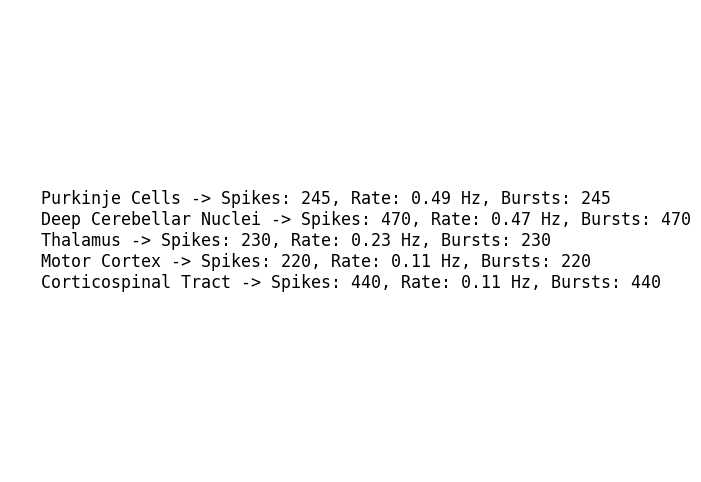

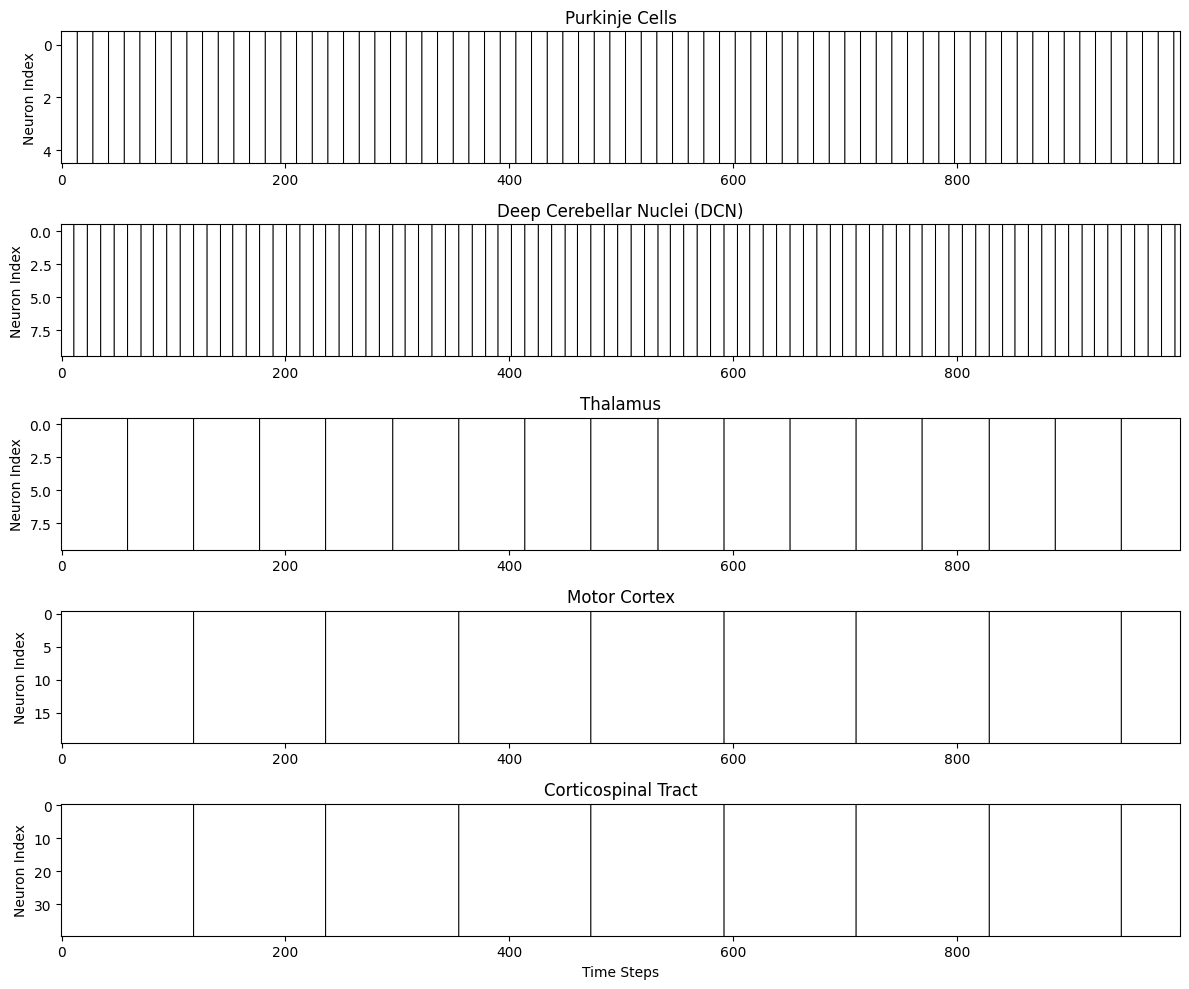

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Simulation and Model Parameters
# ------------------------------
time_steps = 1000  # Total simulation time steps
dt = 0.1           # Time step size in ms

# Doubling the number of cells:
num_purkinje      = 5   # (was 10)
num_dcn           = 10   # (was 5)
num_thalamus      = 10   # (was 5)
num_motor_cortex  = 20   # (was 10)
num_corticospinal = 40   # (was 20)

# Neuron model parameters
tau_mem = 10.0          # Membrane time constant (ms)
threshold = 1.0         # Spiking threshold
resting_potential = 0.0 # Resting membrane potential
reset_potential = 0.0   # Reset potential after spike

# Best configuration parameters (from optimization results)
w_purkinje_dcn_val        = 2.3   # Inhibitory weight from Purkinje to DCN
w_dcn_thalamus_val        = 2.1   # Excitatory weight from DCN to Thalamus
w_thalamus_motor_val      = 3.0   # Excitatory weight from Thalamus to Motor Cortex
w_motor_corticospinal_val = 2.6   # Excitatory weight from Motor Cortex to Corticospinal tract

# Synaptic weights
w_purkinje_dcn        = -w_purkinje_dcn_val * np.ones((num_dcn, num_purkinje))
# Increase excitatory drive downstream by scaling up the weights:
w_dcn_thalamus        = (w_dcn_thalamus_val * 1.2) * np.ones((num_thalamus, num_dcn))
w_thalamus_motor      = (w_thalamus_motor_val * 1.5) * np.ones((num_motor_cortex, num_thalamus))
# Increase the effective weight for corticospinal neurons (from 1.5 to 2.0 multiplier):
w_motor_corticospinal = (w_motor_corticospinal_val * 2.0) * np.ones((num_corticospinal, num_motor_cortex))

# ------------------------------
# Input Setup (No Artificial Noise)
# ------------------------------
# Adjust constant inputs to help balance network activity.
constant_input_purkinje = 8.0    # Lowered drive for Purkinje cells
constant_input_dcn      = 10.0   # Constant drive for DCN
climbing_fiber_input = constant_input_purkinje * np.ones((num_purkinje, time_steps))
mossy_fiber_input    = constant_input_dcn      * np.ones((num_dcn, time_steps))

# Baseline drives for Motor Cortex and Corticospinal tract:
baseline_motor_drive = 0.5       # Baseline drive to Motor Cortex (as before)
baseline_corticospinal = 1.0     # NEW: Baseline drive to Corticospinal neurons

# ------------------------------
# State Variables: Membrane Potentials and Spikes
# ------------------------------
purkinje_membrane      = np.zeros((num_purkinje, time_steps))
dcn_membrane           = np.zeros((num_dcn, time_steps))
thalamus_membrane      = np.zeros((num_thalamus, time_steps))
motor_membrane         = np.zeros((num_motor_cortex, time_steps))
corticospinal_membrane = np.zeros((num_corticospinal, time_steps))

purkinje_spikes      = np.zeros((num_purkinje, time_steps))
dcn_spikes           = np.zeros((num_dcn, time_steps))
thalamus_spikes      = np.zeros((num_thalamus, time_steps))
motor_spikes         = np.zeros((num_motor_cortex, time_steps))
corticospinal_spikes = np.zeros((num_corticospinal, time_steps))

# ------------------------------
# Simulation Loop
# ------------------------------
for t in range(1, time_steps):
    # --- Purkinje Cells ---
    purkinje_input = climbing_fiber_input[:, t]
    purkinje_membrane[:, t] = purkinje_membrane[:, t - 1] + dt / tau_mem * (
        -purkinje_membrane[:, t - 1] + purkinje_input)
    purkinje_spikes[:, t] = (purkinje_membrane[:, t] >= threshold).astype(float)
    purkinje_membrane[purkinje_spikes[:, t] == 1, t] = reset_potential

    # --- Deep Cerebellar Nuclei (DCN) ---
    dcn_input = mossy_fiber_input[:, t] + np.dot(w_purkinje_dcn, purkinje_spikes[:, t])
    dcn_membrane[:, t] = dcn_membrane[:, t - 1] + dt / tau_mem * (
        -dcn_membrane[:, t - 1] + dcn_input)
    dcn_spikes[:, t] = (dcn_membrane[:, t] >= threshold).astype(float)
    dcn_membrane[dcn_spikes[:, t] == 1, t] = reset_potential

    # --- Thalamus ---
    thalamus_input = np.dot(w_dcn_thalamus, dcn_spikes[:, t])
    thalamus_membrane[:, t] = thalamus_membrane[:, t - 1] + dt / tau_mem * (
        -thalamus_membrane[:, t - 1] + thalamus_input)
    thalamus_spikes[:, t] = (thalamus_membrane[:, t] >= threshold).astype(float)
    thalamus_membrane[thalamus_spikes[:, t] == 1, t] = reset_potential

    # --- Motor Cortex ---
    motor_input = np.dot(w_thalamus_motor, thalamus_spikes[:, t]) + baseline_motor_drive
    motor_membrane[:, t] = motor_membrane[:, t - 1] + dt / tau_mem * (
        -motor_membrane[:, t - 1] + motor_input)
    motor_spikes[:, t] = (motor_membrane[:, t] >= threshold).astype(float)
    motor_membrane[motor_spikes[:, t] == 1, t] = reset_potential

    # --- Corticospinal Tract ---
    # Now add a baseline drive to help push these neurons over threshold
    corticospinal_input = np.dot(w_motor_corticospinal, motor_spikes[:, t]) + baseline_corticospinal
    corticospinal_membrane[:, t] = corticospinal_membrane[:, t - 1] + dt / tau_mem * (
        -corticospinal_membrane[:, t - 1] + corticospinal_input)
    corticospinal_spikes[:, t] = (corticospinal_membrane[:, t] >= threshold).astype(float)
    corticospinal_membrane[corticospinal_spikes[:, t] == 1, t] = reset_potential

# ------------------------------
# Updated Quantification Functions
# ------------------------------
def quantify_neurons(spike_data, dt, group_name):
    """
    Quantifies per-neuron metrics and returns list of dictionaries
    """
    sim_time_sec = time_steps * dt / 1000.0  # Total simulation time in seconds
    num_neurons = spike_data.shape[0]
    neuron_stats = []
    
    for neuron_idx in range(num_neurons):
        neuron_spikes = spike_data[neuron_idx, :]
        total_spikes = np.sum(neuron_spikes)
        firing_rate = total_spikes / sim_time_sec
        bursts = np.sum(np.diff(np.insert(neuron_spikes, 0, 0)) == 1)
        
        neuron_stats.append({
            'Group': group_name,
            'Neuron ID': f"{group_name}_N{neuron_idx+1:03d}",
            'Spikes': int(total_spikes),
            'Rate (Hz)': round(firing_rate, 2),
            'Bursts': int(bursts)
        })
    
    return neuron_stats

def save_combined_csv(all_data):
    with open('3[1].csv', 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=[
            'Group', 'Neuron ID', 'Spikes', 'Rate (Hz)', 'Bursts'
        ])
        writer.writeheader()
        writer.writerows(all_data)


# Quantify all neurons
all_neurons = []
groups = [
        ('Purkinje Cells', purkinje_spikes, num_purkinje),
        ('DCN', dcn_spikes, num_dcn),
        ('Thalamus', thalamus_spikes, num_thalamus),
        ('Motor Cortex', motor_spikes, num_motor_cortex),
        ('Corticospinal Tract', corticospinal_spikes, num_corticospinal)
]
    
for group_name, spikes, _ in groups:
    all_neurons.extend(quantify_neurons(spikes, dt, group_name))
    
    # Save combined CSV
save_combined_csv(all_neurons)
    

# ------------------------------
# Save Summary as SVG
# ------------------------------
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')
ax.text(0.05, 0.5, summary_text, fontsize=12, fontfamily='monospace', va='center')
plt.show()
plt.close(fig)

# ------------------------------
# Plot Raster Plots for Each Region
# ------------------------------
plt.figure(figsize=(12, 10))

plt.subplot(5, 1, 1)
plt.title("Purkinje Cells")
plt.imshow(purkinje_spikes, aspect='auto', cmap='binary')
plt.ylabel("Neuron Index")

plt.subplot(5, 1, 2)
plt.title("Deep Cerebellar Nuclei (DCN)")
plt.imshow(dcn_spikes, aspect='auto', cmap='binary')
plt.ylabel("Neuron Index")

plt.subplot(5, 1, 3)
plt.title("Thalamus")
plt.imshow(thalamus_spikes, aspect='auto', cmap='binary')
plt.ylabel("Neuron Index")

plt.subplot(5, 1, 4)
plt.title("Motor Cortex")
plt.imshow(motor_spikes, aspect='auto', cmap='binary')
plt.ylabel("Neuron Index")

plt.subplot(5, 1, 5)
plt.title("Corticospinal Tract")
plt.imshow(corticospinal_spikes, aspect='auto', cmap='binary')
plt.ylabel("Neuron Index")
plt.xlabel("Time Steps")
plt.savefig("3[1].svg", format="svg")
plt.tight_layout()
plt.show()


In [ ]:
#############################################
##########3[2]###############################
#############################################

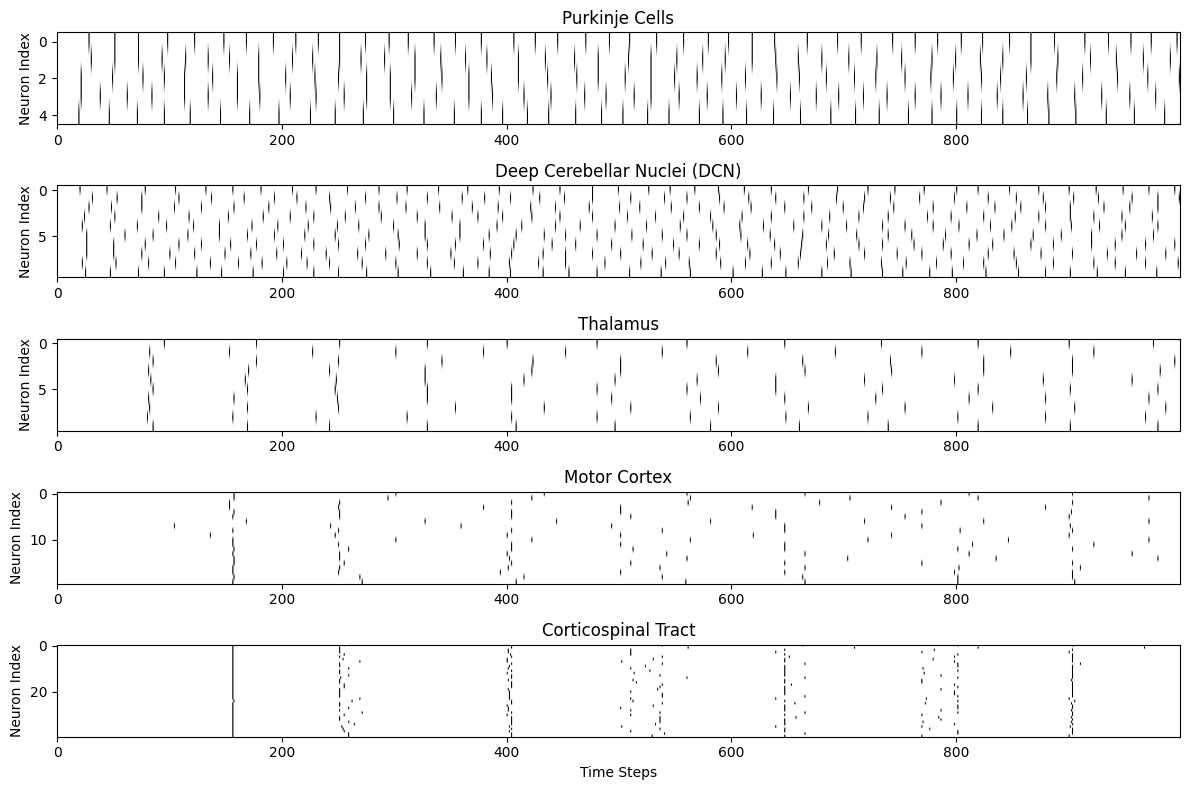

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
time_steps = 1000  # Total simulation time steps
dt = 0.1  # Time step size (ms)
num_purkinje = 5  # Doubled number of Purkinje cells
num_dcn = 10  # Doubled number of DCN neurons
num_thalamus = 10  # Doubled number of thalamic neurons
num_motor_cortex = 20  # Doubled number of motor cortex neurons
num_corticospinal = 40  # Doubled number of corticospinal tract neurons

# Neuron model parameters
tau_mem = 10.0  # Membrane time constant (ms)
threshold = 1.0  # Spiking threshold
resting_potential = 0.0  # Resting membrane potential
reset_potential = 0.0  # Reset potential after spike

# Best configuration parameters (from optimization results)
w_purkinje_dcn_val = 2.3
w_dcn_thalamus_val = 2.1
w_thalamus_motor_val = 3.0
w_motor_corticospinal_val = 2.6
noise_amplitude_val = 2.0

# Synaptic weights
w_purkinje_dcn = -w_purkinje_dcn_val * np.ones((num_dcn, num_purkinje))
w_dcn_thalamus = w_dcn_thalamus_val * np.ones((num_thalamus, num_dcn))
w_thalamus_motor = w_thalamus_motor_val * np.ones((num_motor_cortex, num_thalamus))
w_motor_corticospinal = w_motor_corticospinal_val * np.ones((num_corticospinal, num_motor_cortex))

# Inputs: scaled to increase excitability
climbing_fiber_input = 10.0 * np.random.rand(num_purkinje, time_steps)
mossy_fiber_input = 10.0 * np.random.rand(num_dcn, time_steps)

# Neuron states: membrane potentials and spikes
purkinje_membrane = np.zeros((num_purkinje, time_steps))
dcn_membrane = np.zeros((num_dcn, time_steps))
thalamus_membrane = np.zeros((num_thalamus, time_steps))
motor_membrane = np.zeros((num_motor_cortex, time_steps))
corticospinal_membrane = np.zeros((num_corticospinal, time_steps))

purkinje_spikes = np.zeros((num_purkinje, time_steps))
dcn_spikes = np.zeros((num_dcn, time_steps))
thalamus_spikes = np.zeros((num_thalamus, time_steps))
motor_spikes = np.zeros((num_motor_cortex, time_steps))
corticospinal_spikes = np.zeros((num_corticospinal, time_steps))

# Simulation loop
for t in range(1, time_steps):
    # Purkinje cells
    purkinje_input = climbing_fiber_input[:, t]
    purkinje_membrane[:, t] = purkinje_membrane[:, t - 1] + dt / tau_mem * (-purkinje_membrane[:, t - 1] + purkinje_input)
    purkinje_spikes[:, t] = (purkinje_membrane[:, t] >= threshold).astype(float)
    purkinje_membrane[purkinje_spikes[:, t] == 1, t] = reset_potential

    # Deep cerebellar nuclei (DCN)
    dcn_input = mossy_fiber_input[:, t] + np.dot(w_purkinje_dcn, purkinje_spikes[:, t])
    dcn_membrane[:, t] = dcn_membrane[:, t - 1] + dt / tau_mem * (-dcn_membrane[:, t - 1] + dcn_input)
    dcn_spikes[:, t] = (dcn_membrane[:, t] >= threshold).astype(float)
    dcn_membrane[dcn_spikes[:, t] == 1, t] = reset_potential

    # Thalamus
    thalamus_input = np.dot(w_dcn_thalamus, dcn_spikes[:, t]) + noise_amplitude_val * np.random.rand(num_thalamus)
    thalamus_membrane[:, t] = thalamus_membrane[:, t - 1] + dt / tau_mem * (-thalamus_membrane[:, t - 1] + thalamus_input)
    thalamus_spikes[:, t] = (thalamus_membrane[:, t] >= threshold).astype(float)
    thalamus_membrane[thalamus_spikes[:, t] == 1, t] = reset_potential

    # Motor cortex
    motor_input = np.dot(w_thalamus_motor, thalamus_spikes[:, t]) + noise_amplitude_val * np.random.rand(num_motor_cortex)
    motor_membrane[:, t] = motor_membrane[:, t - 1] + dt / tau_mem * (-motor_membrane[:, t - 1] + motor_input)
    motor_spikes[:, t] = (motor_membrane[:, t] >= threshold).astype(float)
    motor_membrane[motor_spikes[:, t] == 1, t] = reset_potential

    # Corticospinal tract
    corticospinal_input = np.dot(w_motor_corticospinal, motor_spikes[:, t]) + noise_amplitude_val * np.random.rand(num_corticospinal)
    corticospinal_membrane[:, t] = corticospinal_membrane[:, t - 1] + dt / tau_mem * (-corticospinal_membrane[:, t - 1] + corticospinal_input)
    corticospinal_spikes[:, t] = (corticospinal_membrane[:, t] >= threshold).astype(float)
    corticospinal_membrane[corticospinal_spikes[:, t] == 1, t] = reset_potential

# ------------------------------
# Updated Quantification Functions
# ------------------------------
def quantify_neurons(spike_data, dt, group_name):
    """
    Quantifies per-neuron metrics and returns list of dictionaries
    """
    sim_time_sec = time_steps * dt / 1000.0  # Total simulation time in seconds
    num_neurons = spike_data.shape[0]
    neuron_stats = []
    
    for neuron_idx in range(num_neurons):
        neuron_spikes = spike_data[neuron_idx, :]
        total_spikes = np.sum(neuron_spikes)
        firing_rate = total_spikes / sim_time_sec
        bursts = np.sum(np.diff(np.insert(neuron_spikes, 0, 0)) == 1)
        
        neuron_stats.append({
            'Group': group_name,
            'Neuron ID': f"{group_name}_N{neuron_idx+1:03d}",
            'Spikes': int(total_spikes),
            'Rate (Hz)': round(firing_rate, 2),
            'Bursts': int(bursts)
        })
    
    return neuron_stats

def save_combined_csv(all_data):
    with open('3[2].csv', 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=[
            'Group', 'Neuron ID', 'Spikes', 'Rate (Hz)', 'Bursts'
        ])
        writer.writeheader()
        writer.writerows(all_data)


# Quantify all neurons
all_neurons = []
groups = [
        ('Purkinje Cells', purkinje_spikes, num_purkinje),
        ('DCN', dcn_spikes, num_dcn),
        ('Thalamus', thalamus_spikes, num_thalamus),
        ('Motor Cortex', motor_spikes, num_motor_cortex),
        ('Corticospinal Tract', corticospinal_spikes, num_corticospinal)
]
    
for group_name, spikes, _ in groups:
    all_neurons.extend(quantify_neurons(spikes, dt, group_name))
    
    # Save combined CSV
save_combined_csv(all_neurons)


# Plotting results as raster plots and saving as SVG file
plt.figure(figsize=(12, 8))
plt.subplot(5, 1, 1)
plt.title("Purkinje Cells")
plt.imshow(purkinje_spikes, aspect='auto', cmap='binary')
plt.ylabel("Neuron Index")

plt.subplot(5, 1, 2)
plt.title("Deep Cerebellar Nuclei (DCN)")
plt.imshow(dcn_spikes, aspect='auto', cmap='binary')
plt.ylabel("Neuron Index")

plt.subplot(5, 1, 3)
plt.title("Thalamus")
plt.imshow(thalamus_spikes, aspect='auto', cmap='binary')
plt.ylabel("Neuron Index")

plt.subplot(5, 1, 4)
plt.title("Motor Cortex")
plt.imshow(motor_spikes, aspect='auto', cmap='binary')
plt.ylabel("Neuron Index")

plt.subplot(5, 1, 5)
plt.title("Corticospinal Tract")
plt.imshow(corticospinal_spikes, aspect='auto', cmap='binary')
plt.ylabel("Neuron Index")
plt.xlabel("Time Steps")

plt.tight_layout()
plt.savefig("3[2].svg", format="svg")
plt.show()


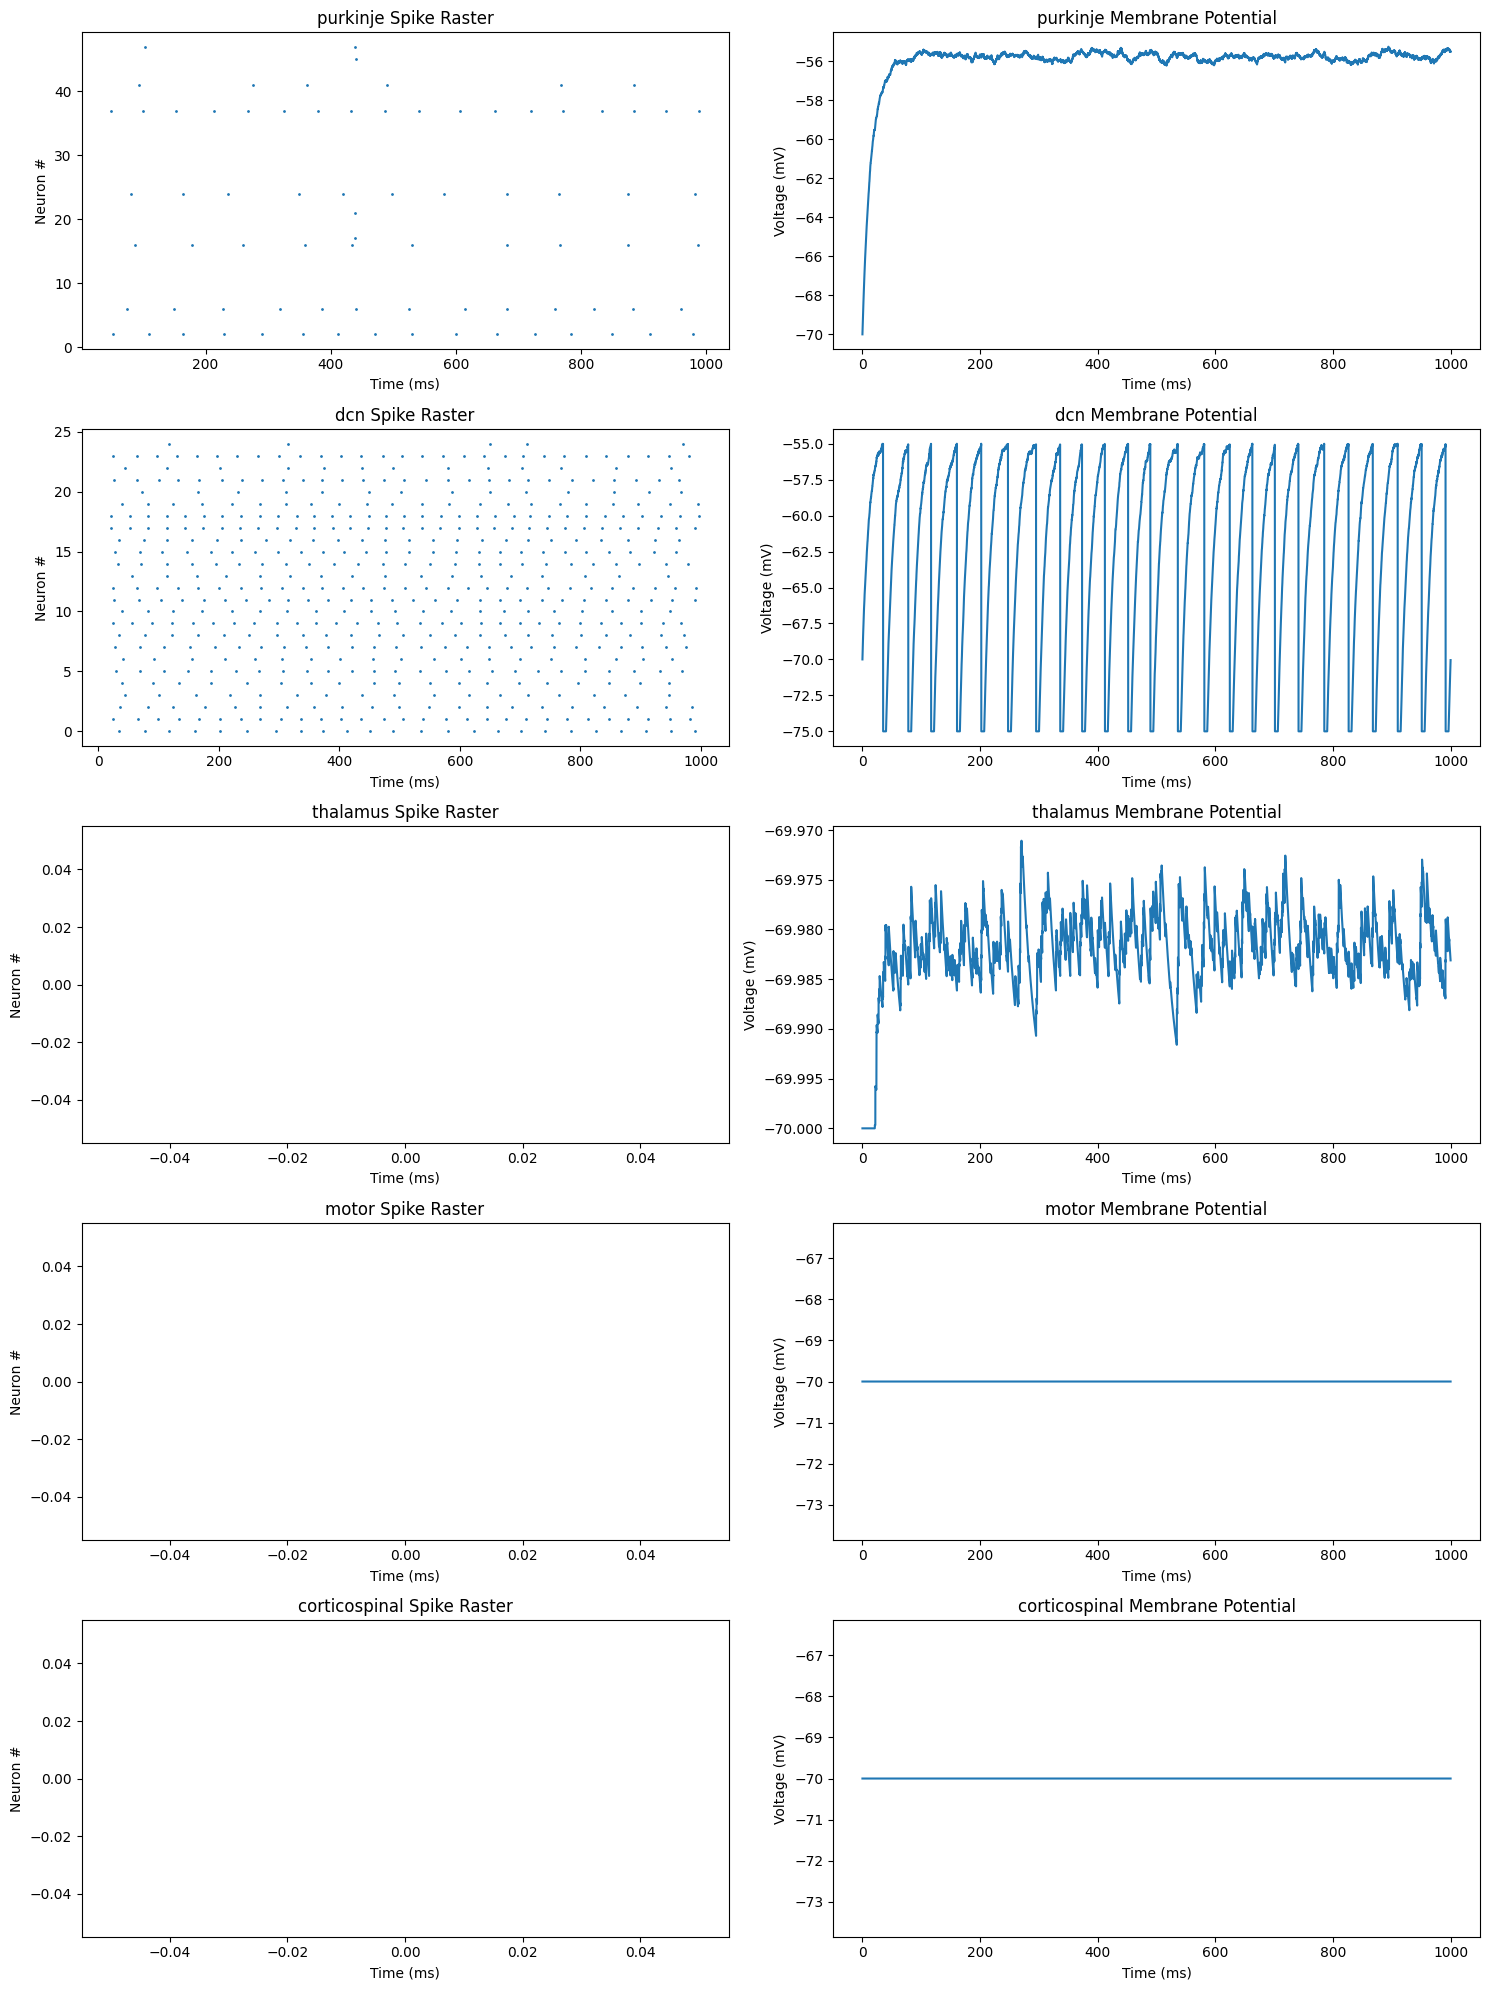

In [40]:
import numpy as np
import matplotlib.pyplot as plt

class CerebellarCircuit:
    def __init__(self):
        # Neuron counts
        self.num_purkinje = 50
        self.num_dcn = 25
        self.num_thalamus = 30
        self.num_motor = 40
        self.num_corticospinal = 45

        # Simulation parameters
        self.dt = 0.1  # ms
        self.T = 1000  # ms
        self.time_steps = int(self.T / self.dt)
        self.time = np.arange(0, self.T, self.dt)

        # Adjusted neuron parameters
        self.params = {
            'V_rest': -70.0,    # mV
            'V_thresh': -55.0,  # mV
            'V_reset': -75.0,   # mV
            'tau_m': {
                'purkinje': 15.0,
                'dcn': 12.0,
                'thalamus': 20.0,
                'motor': 25.0,
                'corticospinal': 20.0
            },
            'refractory_period': 5.0  # ms
        }

        # Initialize states
        self.V = self._initialize_voltages()
        self.spikes = self._initialize_spikes()
        self.weights = self._initialize_weights()
        self.refractory_counters = {k: np.zeros(v.shape[0]) for k, v in self.V.items()}

    def _initialize_voltages(self):
        """Initialize membrane potentials for all neuron populations"""
        return {
            'purkinje': self.params['V_rest'] * np.ones((self.num_purkinje, self.time_steps)),
            'dcn': self.params['V_rest'] * np.ones((self.num_dcn, self.time_steps)),
            'thalamus': self.params['V_rest'] * np.ones((self.num_thalamus, self.time_steps)),
            'motor': self.params['V_rest'] * np.ones((self.num_motor, self.time_steps)),
            'corticospinal': self.params['V_rest'] * np.ones((self.num_corticospinal, self.time_steps))
        }

    def _initialize_spikes(self):
        """Initialize spike records for all neuron populations"""
        return {
            'purkinje': np.zeros((self.num_purkinje, self.time_steps)),
            'dcn': np.zeros((self.num_dcn, self.time_steps)),
            'thalamus': np.zeros((self.num_thalamus, self.time_steps)),
            'motor': np.zeros((self.num_motor, self.time_steps)),
            'corticospinal': np.zeros((self.num_corticospinal, self.time_steps))
        }

    def _initialize_weights(self):
        """Initialize synaptic weights between layers"""
        return {
            'parallel_purkinje': 0.3 * np.random.rand(self.num_purkinje, 100),
            'climbing_purkinje': 1.0 * np.random.rand(self.num_purkinje, 1),
            'purkinje_dcn': -0.5 * np.random.rand(self.num_dcn, self.num_purkinje),
            'mossy_dcn': 0.4 * np.random.rand(self.num_dcn, 100),
            'dcn_thalamus': 0.8 * np.random.rand(self.num_thalamus, self.num_dcn),
            'thalamus_motor': 0.7 * np.random.rand(self.num_motor, self.num_thalamus),
            'motor_cortico': 0.6 * np.random.rand(self.num_corticospinal, self.num_motor),
            'motor_dcn': 0.2 * np.random.rand(self.num_dcn, self.num_motor)
        }

    def _update_layer(self, layer_name, t, inputs):
        if self.refractory_counters[layer_name].any() > 0:
            self.refractory_counters[layer_name] -= self.dt
            
        tau = self.params['tau_m'][layer_name]
        v = self.V[layer_name][:, t-1]
        
        # Only update non-refractory neurons
        active_mask = self.refractory_counters[layer_name] <= 0
        
        if active_mask.any():
            dv = (-v[active_mask] + self.params['V_rest'] + inputs[active_mask]) / tau
            v_new = v.copy()
            v_new[active_mask] += self.dt * dv
            
            # Spike generation
            spiking = v_new >= self.params['V_thresh']
            v_new[spiking] = self.params['V_reset']
            self.refractory_counters[layer_name][spiking] = self.params['refractory_period']
            
            self.spikes[layer_name][:, t] = spiking
            self.V[layer_name][:, t] = v_new

    def _generate_inputs(self):
        # Reduced input strengths
        pf = np.random.poisson(0.3, (100, self.time_steps)) * 3.0
        cf = np.random.poisson(0.05, (1, self.time_steps)) * 10.0
        mf = np.random.poisson(0.2, (100, self.time_steps)) * 4.0
        return pf, cf, mf

    def simulate(self):
        pf_input, cf_input, mf_input = self._generate_inputs()
        
        for t in range(1, self.time_steps):
            # Purkinje cells
            purk_input = (np.dot(self.weights['parallel_purkinje'], pf_input[:, t]) + 
                         np.dot(self.weights['climbing_purkinje'], cf_input[:, t]))
            self._update_layer('purkinje', t, purk_input)
            
            # DCN
            dcn_input = (np.dot(self.weights['purkinje_dcn'], self.spikes['purkinje'][:, t-1]) +
                        np.dot(self.weights['mossy_dcn'], mf_input[:, t]) +
                        np.dot(self.weights['motor_dcn'], self.spikes['motor'][:, t-1]))
            self._update_layer('dcn', t, dcn_input)
            
            # Thalamus
            thal_input = np.dot(self.weights['dcn_thalamus'], self.spikes['dcn'][:, t-1])
            self._update_layer('thalamus', t, thal_input)
            
            # Motor cortex
            motor_input = np.dot(self.weights['thalamus_motor'], self.spikes['thalamus'][:, t-1])
            self._update_layer('motor', t, motor_input)
            
            # Corticospinal
            cortico_input = np.dot(self.weights['motor_cortico'], self.spikes['motor'][:, t-1])
            self._update_layer('corticospinal', t, cortico_input)

    def visualize_results(self):
        fig, axes = plt.subplots(5, 2, figsize=(15, 20))
        populations = ['purkinje', 'dcn', 'thalamus', 'motor', 'corticospinal']
        
        for i, pop in enumerate(populations):
            # Spike raster
            spikes = np.where(self.spikes[pop])
            axes[i, 0].scatter(spikes[1] * self.dt, spikes[0], s=1)
            axes[i, 0].set_title(f'{pop} Spike Raster')
            axes[i, 0].set_xlabel('Time (ms)')
            axes[i, 0].set_ylabel('Neuron #')
            
            # Membrane potential
            axes[i, 1].plot(self.time, self.V[pop][0, :])
            axes[i, 1].set_title(f'{pop} Membrane Potential')
            axes[i, 1].set_xlabel('Time (ms)')
            axes[i, 1].set_ylabel('Voltage (mV)')
        
        plt.tight_layout()
        plt.show()

# Run the simulation
circuit = CerebellarCircuit()
circuit.simulate()
circuit.visualize_results()
